In [1]:
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
import os
import re
from scipy.optimize import curve_fit

from jaqalpaq.parser import parse_jaqal_string
from jaqalpaq.emulator import run_jaqal_circuit

mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'cm'

Load the raw RAV and XEB shot data from the QSCOUT run.

In [2]:
rav_shot_data = np.load("data/qscout/RAV_shot_data.npy")
xeb_shot_data = np.load("data/qscout/XEB_shot_data.npy")

k_list = [5, 10, 25, 50, 100]

In [3]:
DIM = 4   # 2-qubit circuits

def gaussian_func(x, alpha):
    return alpha**(x**2)
        
def get_2Q_gate_count(jaqal):
    code_array = jaqal.split("\n")
    code_array = code_array[5:-1]
    total_2q_gate_count = 0
    for rotation in code_array:
        rotation_array = rotation.split(" ")
        gate_type = rotation_array[0]
        if gate_type.startswith("MS"):
            total_2q_gate_count += 1
    return total_2q_gate_count

## RAV

In [4]:
rav_alphas = {}
rav_error_rates = {}

for k in k_list:
    shots_per_run = k
    run_count = rav_shot_data.shape[-1] // shots_per_run

    rav_run_probs = []
    for run_idx in range(run_count):
        run_shot_data = rav_shot_data[:,:,shots_per_run*run_idx:shots_per_run*(run_idx+1)]
        run_probs = np.array([
            [np.mean(run_shot_data[circuit_idx][result_idx]) for result_idx in range(len(run_shot_data[circuit_idx]))]
            for circuit_idx in range(len(run_shot_data))
        ])
        rav_run_probs.append(run_probs)
    rav_run_probs = np.array(rav_run_probs)
    
    def files_to_list(directory):
        jaqal_files = [f'{directory}/{f}' for f in os.listdir(directory)]
        jaqal_circuits = []
        for jaqal_file in jaqal_files:
            with open(jaqal_file, mode='r') as f:
                jaqal = ''.join(f.readlines())
                circuit_i = int(re.search('rav\/(.*)_1.txt', jaqal_file).group(1))
                circuit_i = (circuit_i // 2) - 1  # convert circuit_i to an index between 0 and 49
                assert 0 <= circuit_i and circuit_i <= 49
                total_2q_gate_count = get_2Q_gate_count(jaqal)
                rav_circuit_results = run_jaqal_circuit(parse_jaqal_string(jaqal))
                pure_probs = rav_circuit_results.subcircuits[0].probability_by_int
                sampled_probs = rav_run_probs[:,circuit_i,:]
                jaqal_circuits.append({
                    'circuit_i': circuit_i,
                    'jaqal': jaqal,
                    'cycle_depth': total_2q_gate_count,
                    'pure_probs': pure_probs,
                    'sampled_probs': sampled_probs,
                })
        return jaqal_circuits

    dir_name = "data/sequences/rav"
    records = files_to_list(dir_name)
    
    records_by_run = [copy.deepcopy(records) for _ in range(run_count)]
    for run_idx, records in enumerate(records_by_run):
        for record in records:
            record.update(
                sampled_probs=record['sampled_probs'][run_idx],
            )
    
    rav_alphas[k] = []
    for run_idx, records in enumerate(records_by_run):
        fidelities = [(record["sampled_probs"][0] - 1/DIM) / (record["pure_probs"][0] - 1/DIM) for record in records]
        total_layer_counts = [record["cycle_depth"] for record in records]
        x_RAV = np.linspace(min(total_layer_counts), max(total_layer_counts), 100)
        popt_RAV, pcov = curve_fit(gaussian_func, total_layer_counts, fidelities)
        alpha_RAV = popt_RAV[0]
        rav_alphas[k].append(alpha_RAV)
    
    rav_error_rates[k] = [np.sqrt(1-alpha) for alpha in rav_alphas[k]]

## XEB

In [5]:
xeb_alphas = {}
xeb_error_rates = {}

for k in k_list:
    shots_per_run = k
    run_count = xeb_shot_data.shape[-1] // shots_per_run

    xeb_run_probs = []
    for run_idx in range(run_count):
        run_shot_data = xeb_shot_data[:,:,shots_per_run*run_idx:shots_per_run*(run_idx+1)]
        run_probs = np.array([
            [np.mean(run_shot_data[circuit_idx][result_idx]) for result_idx in range(len(run_shot_data[circuit_idx]))]
            for circuit_idx in range(len(run_shot_data))
        ])
        xeb_run_probs.append(run_probs)
    xeb_run_probs = np.array(xeb_run_probs)
    
    def files_to_list(directory):
        jaqal_files = [f'{directory}/{f}' for f in os.listdir(directory)]
        jaqal_circuits = []
        for jaqal_file in jaqal_files:
            with open(jaqal_file, mode='r') as f:
                jaqal = ''.join(f.readlines())
                circuit_i = int(re.search('xeb\/(.*)_1.txt', jaqal_file).group(1))
                circuit_i = (circuit_i // 2) - 1  # convert circuit_i to an index between 0 and 49
                assert 0 <= circuit_i and circuit_i <= 49
                total_2q_gate_count = get_2Q_gate_count(jaqal)
                xeb_circuit_results = run_jaqal_circuit(parse_jaqal_string(jaqal))
                pure_probs = xeb_circuit_results.subcircuits[0].probability_by_int
                sampled_probs = xeb_run_probs[:,circuit_i,:]
                jaqal_circuits.append({
                    'circuit_i': circuit_i,
                    'jaqal': jaqal,
                    'cycle_depth': total_2q_gate_count,
                    'pure_probs': pure_probs,
                    'sampled_probs': sampled_probs,
                })
        return jaqal_circuits

    dir_name = "data/sequences/xeb"
    records = files_to_list(dir_name)
    
    records_by_run = [copy.deepcopy(records) for _ in range(run_count)]
    for run_idx, records in enumerate(records_by_run):
        for record in records:
            e_u = np.sum(record['pure_probs']**2)
            u_u = np.sum(record['pure_probs']) / DIM
            m_u = np.sum(record['pure_probs'] * record['sampled_probs'][run_idx])
            record.update(
                sampled_probs=record['sampled_probs'][run_idx],
                e_u=e_u,
                u_u=u_u,
                m_u=m_u,
            )
    
    xeb_alphas[k] = []
    for run_idx, records in enumerate(records_by_run):
        fidelities = []
        for record in records:
            e_u = np.sum(record["pure_probs"]**2)
            u_u = np.sum(record["pure_probs"]) / DIM
            m_u = np.sum(record["pure_probs"] * record["sampled_probs"])
            y = record["m_u"] - record["u_u"]
            x = record["e_u"] - record["u_u"]
            xeb_fidelity = (x * y) / (x ** 2)
            fidelities.append(xeb_fidelity)
        total_layer_counts = [record["cycle_depth"] for record in records]

        x_XEB = np.linspace(min(total_layer_counts), max(total_layer_counts), 100)
        popt_XEB, pcov = curve_fit(gaussian_func, total_layer_counts, fidelities)
        alpha_XEB = popt_XEB[0]
        xeb_alphas[k].append(alpha_XEB)

    xeb_error_rates[k] = [np.sqrt(1-alpha) for alpha in xeb_alphas[k]]

## Plot for Figure 8(c)

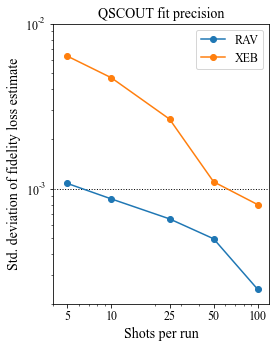

In [6]:
plt.figure(figsize=(4,5))

plt.plot(k_list, [np.std(rav_error_rates[k]) for k in k_list], 'o-', label="RAV")
plt.plot(k_list, [np.std(xeb_error_rates[k]) for k in k_list], 'o-', label="XEB")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r'Shots per run', fontsize=14)
plt.ylabel(f'Std. deviation of fidelity loss estimate', fontsize=14)

plt.xticks(ticks=k_list, labels=k_list)

plt.xlim(4, 120)
plt.ylim(2e-4, 1e-2)
plt.hlines(1e-3, xmin=0, xmax=200, color='black', linestyle='dotted', linewidth=1)

plt.title('QSCOUT fit precision', fontsize=14)

plt.tight_layout()
plt.legend()

plt.savefig(f'fig8c.pdf', bbox_inches='tight')
plt.show()

## Data for Figure 8(d)

In [7]:
[(k,
  np.mean(rav_error_rates[k]),
  np.std(rav_error_rates[k]),
  np.std(rav_error_rates[k])/np.mean(rav_error_rates[k])
) for k in rav_error_rates]

[(5, 0.014072891763308022, 0.0010750447928841423, 0.07639117893929134),
 (10, 0.014041390527639275, 0.0008655647168005882, 0.06164380337522827),
 (25, 0.014029970099484385, 0.0006549018756296108, 0.04667877914106738),
 (50, 0.014020372139017856, 0.0004959573916823802, 0.03537405332502983),
 (100, 0.014015309631578293, 0.0002448205702771001, 0.01746808145611624)]

In [8]:
[(k,
  np.mean(xeb_error_rates[k]),
  np.std(xeb_error_rates[k]),
  np.std(xeb_error_rates[k])/np.mean(xeb_error_rates[k])
) for k in xeb_error_rates]

[(5, 0.015059043567464325, 0.006365290457683881, 0.4226888931669173),
 (10, 0.014633374108975366, 0.00470168738536278, 0.32129892602684196),
 (25, 0.01398605964356646, 0.0026381460202351804, 0.18862682467171651),
 (50, 0.013530115504266717, 0.0010989383969896667, 0.08122165672888135),
 (100, 0.013446284818174054, 0.0007992435895170337, 0.05943973374985875)]

In [9]:
[(k,
  ((np.std(xeb_error_rates[k])/np.mean(xeb_error_rates[k]))
   /(np.std(rav_error_rates[k])/np.mean(rav_error_rates[k])))
) for k in xeb_error_rates]

[(5, 5.533215994779075),
 (10, 5.212185303867165),
 (25, 4.040954543855349),
 (50, 2.296080010469449),
 (100, 3.4027625700730084)]